In [23]:
import pandas as pd
import numpy as np
from fastai.structured import *
from fastai.column_data import *
from sklearn import metrics
from metrics import print_metrics_binary
from tqdm import TqdmSynchronisationWarning
np.set_printoptions(threshold=50, edgeitems=20)

In [24]:
#print(torch.cuda.current_device())
#torch.cuda.set_device(1)

In [25]:
warnings.filterwarnings("ignore", category=TqdmSynchronisationWarning)

In [26]:
train = pd.read_csv('./datasets/ihm/train.csv')
test = pd.read_csv('./datasets/ihm/test.csv')
val = pd.read_csv('./datasets/ihm/val.csv')
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)
val = val.drop('Unnamed: 0', axis=1)

In [27]:
print(len(train[train['Mortality'] == 1]))
print(len(train[train['Mortality'] == 0]))

180592
1014121


In [28]:
def balance_dataset(df):
    split_set = []
    num_survived = 0
    num_died = 0
    for episode, df_episode in df.groupby('Episode'):
        split_set.append(df_episode)
        if df_episode.iloc[0]['Mortality'] < 1:
            num_survived = num_survived +1
        else:
            num_died = num_died +1
    counter = 0
    for patient in split_set:
        if patient.iloc[0]['Mortality'] == 1 and num_died < num_survived:
            split_set.append(patient)
            counter = counter +1
            num_died = num_died +1
    print(num_died, num_survived)
    complete_data =  pd.DataFrame(columns=df.columns)
    for patient in split_set:
        complete_data = pd.concat([complete_data,patient])
    return complete_data




#train_balanced = balance_dataset(train)

In [29]:
print(len(train[train['Mortality'] == 1]))
print(len(train[train['Mortality'] == 0]))


print(len(val[val['Mortality'] == 1]))
print(len(val[val['Mortality'] == 0]))


180592
1014121
38996
224337


In [30]:
train_size = len(train)
train = train.append(val)


print(train_size)
print(len(train))
val_idx = list(range(train_size, len(train)))

1194713
1458046


In [31]:
cat_vars = ['Capillary refill rate', 'Glascow coma scale eye opening' ,'Glascow coma scale motor response','Glascow coma scale total', 'Glascow coma scale verbal response','Episode' ]


for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()
for v in cat_vars: test[v] = test[v].astype('category').cat.as_ordered()

cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]

print(cat_sz)

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

[('Capillary refill rate', 3), ('Glascow coma scale eye opening', 6), ('Glascow coma scale motor response', 7), ('Glascow coma scale total', 14), ('Glascow coma scale verbal response', 6), ('Episode', 17904)]


In [32]:
print(len(train[train['Mortality'] == 1]))
print(len(train[train['Mortality'] == 0]))

219588
1238458


In [33]:
df, y, nas, mapper = proc_df(train, 'Mortality', do_scale=True)
df_test, y_test, nas_test, mapper_test = proc_df(test, do_scale=True, mapper=mapper, na_dict=nas) 

md = ColumnarModelData.from_data_frame('./datasets/ihm/', val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=16,
                                       test_df=df_test)

In [34]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [2000,1000,500,250], [0.4,0.3, 0.3,0.3], y_range=[0,1])

/home/andreas/Documents/HospitalMortalityRate/fastai/column_data.py:101: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
/home/andreas/Documents/HospitalMortalityRate/fastai/column_data.py:103: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.outp.weight.data)


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 23%|██▎       | 17070/74670 [01:46<05:58, 160.58it/s, loss=0.00688]

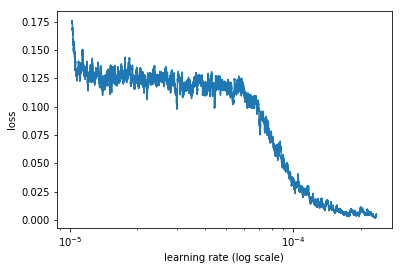

In [35]:
m.lr_find()
m.sched.plot(100)


In [36]:
lr = 0.0001


def roc_auc(preds, y):
    print(y)
    preds = np.exp(preds) #conv from log
    return metrics.roc_auc_score(y, preds, average="micro")

def accuracy1(preds, targs):
    #if np.array(targs.long()).max() == 1:
        #print(preds, targs)
    #print ('preds: {}, {}'.format(preds.ceil() ,type(preds)))
    #print ('targs: {}, {}'.format(targs.ceil() ,type(targs)))
    return (preds.long()==targs.long()).float().mean()


In [37]:
lrs = [lr/9, lr/6, lr/3]

In [38]:
m.fit(lrs, 2, cycle_len=2, cycle_mult=2, metrics=[accuracy1])

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy1                           
    0      0.000328   0.266309   0.769083  
    1      0.0        0.263426   0.769543                            
    2      0.0        0.292367   0.715482                            
    3      0.0        0.263765   0.743458                            
    4      2.2e-05    0.244131   0.761439                            
    5      0.0        0.263005   0.744411                            


[0.26300527975174065, 0.7444110688747707]

In [39]:


m.fit(lrs, 2, cycle_len=2, cycle_mult=2, metrics=[accuracy1])

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy1                           
    0      0.0        0.236055   0.767428  
    1      0.0        0.264196   0.742129                            
    2      0.0        0.255354   0.748926                            
    3      0.0        0.221787   0.781774                            
    4      0.0        0.253517   0.750107                            
    5      0.0        0.252504   0.751                               


[0.25250380313326654, 0.7509996848097276]

In [40]:
def split_test_set(df):
    split_set = []
    for episode, df_episode in df.groupby('Episode'):
        split_set.append(df_episode)
    return split_set

test_split = split_test_set(df_test)

In [41]:

y_predicted = []
y_true = []
counter = 1
for patient in test_split:
    print(str(counter) + '/' + str(len(test_split)))
    counter=counter+1
    y_true.append(patient.iloc[0]['Mortality'])
    m._set_test_data(patient.drop('Mortality', axis=1))
    y_predicted. = m.predict().max()
    

1/3236
2/3236
3/3236
4/3236
5/3236
6/3236
7/3236
8/3236
9/3236
10/3236
11/3236
12/3236
13/3236
14/3236
15/3236
16/3236
17/3236
18/3236
19/3236
20/3236
21/3236
22/3236
23/3236
24/3236
25/3236
26/3236
27/3236
28/3236
29/3236
30/3236
31/3236
32/3236
33/3236
34/3236
35/3236
36/3236
37/3236
38/3236
39/3236
40/3236
41/3236
42/3236
43/3236
44/3236
45/3236
46/3236
47/3236
48/3236
49/3236
50/3236
51/3236
52/3236
53/3236
54/3236
55/3236
56/3236
57/3236
58/3236
59/3236
60/3236
61/3236
62/3236
63/3236
64/3236
65/3236
66/3236
67/3236
68/3236
69/3236
70/3236
71/3236
72/3236
73/3236
74/3236
75/3236
76/3236
77/3236
78/3236
79/3236
80/3236
81/3236
82/3236
83/3236
84/3236
85/3236
86/3236
87/3236
88/3236
89/3236
90/3236
91/3236
92/3236
93/3236
94/3236
95/3236
96/3236
97/3236
98/3236
99/3236
100/3236
101/3236
102/3236
103/3236
104/3236
105/3236
106/3236
107/3236
108/3236
109/3236
110/3236
111/3236
112/3236
113/3236
114/3236
115/3236
116/3236
117/3236
118/3236
119/3236
120/3236
121/3236
122/3236
123/3236
1

924/3236
925/3236
926/3236
927/3236
928/3236
929/3236
930/3236
931/3236
932/3236
933/3236
934/3236
935/3236
936/3236
937/3236
938/3236
939/3236
940/3236
941/3236
942/3236
943/3236
944/3236
945/3236
946/3236
947/3236
948/3236
949/3236
950/3236
951/3236
952/3236
953/3236
954/3236
955/3236
956/3236
957/3236
958/3236
959/3236
960/3236
961/3236
962/3236
963/3236
964/3236
965/3236
966/3236
967/3236
968/3236
969/3236
970/3236
971/3236
972/3236
973/3236
974/3236
975/3236
976/3236
977/3236
978/3236
979/3236
980/3236
981/3236
982/3236
983/3236
984/3236
985/3236
986/3236
987/3236
988/3236
989/3236
990/3236
991/3236
992/3236
993/3236
994/3236
995/3236
996/3236
997/3236
998/3236
999/3236
1000/3236
1001/3236
1002/3236
1003/3236
1004/3236
1005/3236
1006/3236
1007/3236
1008/3236
1009/3236
1010/3236
1011/3236
1012/3236
1013/3236
1014/3236
1015/3236
1016/3236
1017/3236
1018/3236
1019/3236
1020/3236
1021/3236
1022/3236
1023/3236
1024/3236
1025/3236
1026/3236
1027/3236
1028/3236
1029/3236
1030/3236
1031/3

1751/3236
1752/3236
1753/3236
1754/3236
1755/3236
1756/3236
1757/3236
1758/3236
1759/3236
1760/3236
1761/3236
1762/3236
1763/3236
1764/3236
1765/3236
1766/3236
1767/3236
1768/3236
1769/3236
1770/3236
1771/3236
1772/3236
1773/3236
1774/3236
1775/3236
1776/3236
1777/3236
1778/3236
1779/3236
1780/3236
1781/3236
1782/3236
1783/3236
1784/3236
1785/3236
1786/3236
1787/3236
1788/3236
1789/3236
1790/3236
1791/3236
1792/3236
1793/3236
1794/3236
1795/3236
1796/3236
1797/3236
1798/3236
1799/3236
1800/3236
1801/3236
1802/3236
1803/3236
1804/3236
1805/3236
1806/3236
1807/3236
1808/3236
1809/3236
1810/3236
1811/3236
1812/3236
1813/3236
1814/3236
1815/3236
1816/3236
1817/3236
1818/3236
1819/3236
1820/3236
1821/3236
1822/3236
1823/3236
1824/3236
1825/3236
1826/3236
1827/3236
1828/3236
1829/3236
1830/3236
1831/3236
1832/3236
1833/3236
1834/3236
1835/3236
1836/3236
1837/3236
1838/3236
1839/3236
1840/3236
1841/3236
1842/3236
1843/3236
1844/3236
1845/3236
1846/3236
1847/3236
1848/3236
1849/3236
1850/3236


2571/3236
2572/3236
2573/3236
2574/3236
2575/3236
2576/3236
2577/3236
2578/3236
2579/3236
2580/3236
2581/3236
2582/3236
2583/3236
2584/3236
2585/3236
2586/3236
2587/3236
2588/3236
2589/3236
2590/3236
2591/3236
2592/3236
2593/3236
2594/3236
2595/3236
2596/3236
2597/3236
2598/3236
2599/3236
2600/3236
2601/3236
2602/3236
2603/3236
2604/3236
2605/3236
2606/3236
2607/3236
2608/3236
2609/3236
2610/3236
2611/3236
2612/3236
2613/3236
2614/3236
2615/3236
2616/3236
2617/3236
2618/3236
2619/3236
2620/3236
2621/3236
2622/3236
2623/3236
2624/3236
2625/3236
2626/3236
2627/3236
2628/3236
2629/3236
2630/3236
2631/3236
2632/3236
2633/3236
2634/3236
2635/3236
2636/3236
2637/3236
2638/3236
2639/3236
2640/3236
2641/3236
2642/3236
2643/3236
2644/3236
2645/3236
2646/3236
2647/3236
2648/3236
2649/3236
2650/3236
2651/3236
2652/3236
2653/3236
2654/3236
2655/3236
2656/3236
2657/3236
2658/3236
2659/3236
2660/3236
2661/3236
2662/3236
2663/3236
2664/3236
2665/3236
2666/3236
2667/3236
2668/3236
2669/3236
2670/3236


In [42]:

for pred in pred_test:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)

NameError: name 'pred_test' is not defined

In [22]:
y_true[-1]

1.0

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
confusion_matrix(y_true, y_predicted)

TypeError: Singleton array 1.0 cannot be considered a valid collection.

In [ ]:
metrics.roc_auc_score(y_true, y_predicted, average="micro")

In [ ]:
print_metrics_binary(y_true, y_predicted)
